In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import cmasher as cmm
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import plotly.express as px
import scipy
from epics import ca
from IPython.display import Image, display_png

ca.finalize_libca()

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [3]:
%matplotlib inline

In [4]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [5]:
exp_type = "peak_fwhm_nlpi"

In [6]:
# base_dir = Path(aps.__file__).parents[1]
# autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type / "all_motors_worse"
print(f"data base dir exists {data_base_dir.exists()}")

data base dir exists True


In [7]:
!ls {data_base_dir}

initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-22_images
peak_fwhm_nlpi_moo_100_2022-11-22_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_10:19.gz


### peak_fwhm_150_2022-11-21

In [8]:
!ls {data_base_dir}

initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-22_images
peak_fwhm_nlpi_moo_100_2022-11-22_steps
peak_fwhm_nlpi_moo_autofocusing.ini
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_10:19.gz


In [9]:
log_file = Path(data_base_dir / "peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_10:19.gz")
log_file.exists()

True

In [10]:
hist_dir = Path(data_base_dir / "peak_fwhm_nlpi_moo_100_2022-11-22_steps")
hist_dir.exists()

True

In [11]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/peak_fwhm_nlpi")
base_out_dir.mkdir(exist_ok=True)

In [12]:
out_dir = base_out_dir / "all_motors_worse"
out_dir.mkdir(exist_ok=True)

In [13]:
study = analysis.create_study_from_trials(log_file, n_objectives=3)

[I 2023-08-07 17:08:29,524] A new study created in memory with name: no-name-c3d727ab-d59a-4a33-b12a-57c307785e87


Assuming minimization for all objectives.


In [14]:
n_steps = len(study.trials)

In [15]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="gz")

In [16]:
reference = joblib.load("reference_beam.joblib")
ref_hist = reference["hist"]
ref_dw = reference["dw"]

In [17]:
max_count = np.maximum(np.max([h.data_2D for h in hists]), reference["hist"].data_2D.max())

Trial values: peak_distance 2.537e-01 fwhm 9.638e-02 nlpi -9.878e+00
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39654798529356095, 'h_fwhm': 0.012355720240853074, 'h_centroid': -0.0035970749534196544, 'h_peak': -0.08876609541454379, 'v_sigma': 0.46633800863702407, 'v_fwhm': 0.09558733880422499, 'v_centroid': -0.0026490776445018682, 'v_peak': 0.23766783899960922, 'integral_intensity': 275.82872363614695, 'peak_intensity': 19490.25, 'gaussian_fit': {}}}
Trial mots
dict_items([('hb_1', 0.0), ('hb_2', 0.0), ('hb_pitch', 0.0), ('hb_trans', 0.0), ('vb_bender', 0.0), ('vb_pitch', 0.0), ('vb_trans', 0.0)])


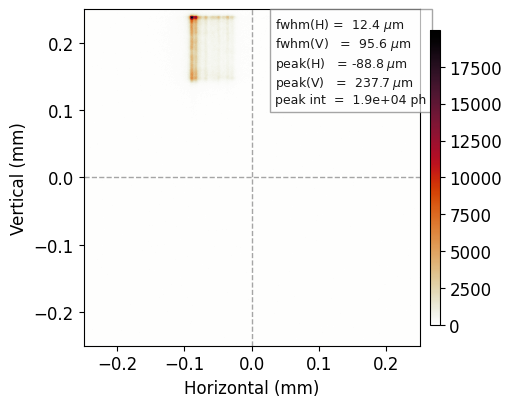

In [18]:
print(
    f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} "
    + f"nlpi {study.trials[0].values[2]:4.3e}"
)
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)

dwd = dict(**study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary)

print('Trial mots')
print(study.trials[0].params.items())


plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(
    hists[0].hh,
    hists[0].vv,
    hists[0].data_2D.T[::-1],
    cmap=apu.CMAP,
    #norm=mpl.colors.LogNorm(100, max_count),
    rasterized=True,
)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title("Initial")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph"
)
ax.text(
    0.035, 0.11, text, color="black", alpha=0.9, fontsize=9, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)
#plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
plt.show()

In [19]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [20]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[14, 81, 86, 57, 80, 91, 87]
88 [0.0037071853483713556, 0.015166689854093524, -11.083139419555664]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3968078903818005, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0008661593715613147, 'h_peak': -0.0029263547938860714, 'v_sigma': 0.46511471960479805, 'v_fwhm': 0.013005080109418365, 'v_centroid': 0.005690764961103961, 'v_peak': -0.0022758890191481784, 'integral_intensity': 275.1684382238761, 'peak_intensity': 65064.848, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.015166689854093524


Trial number 26
Trial values: peak_distance 2.375e-01 fwhm 1.150e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.400441484013916, 'h_fwhm': 0.008453913849004735, 'h_centroid': 0.0032084223218796504, 'h_peak': 0.1596489115331172, 'v_sigma': 0.4693920107076215, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.001411755436126566, 'v_peak': 0.17589370847987496, 'integral_intensity': 270.80667906756435, 'peak_intensity': 46737.0, 'gaussian_fit': {}}}
Params:
{'hb_1': -25.0, 'hb_2': 8.0, 'hb_pitch': -0.0012499999999999998, 'hb_trans': -0.1372, 'vb_bender': -55.0, 'vb_pitch': -0.00275, 'vb_trans': 0.15300000000000002}


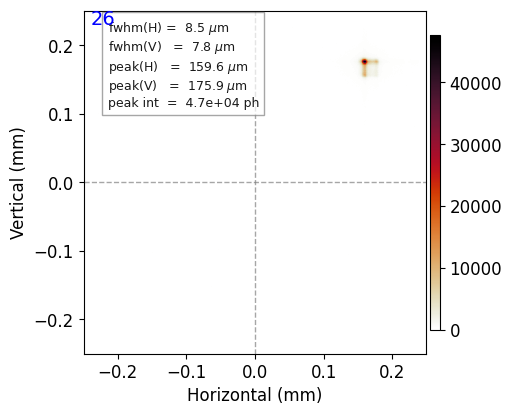

Trial number 44
Trial values: peak_distance 7.197e-03 fwhm 1.428e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39782393200670646, 'h_fwhm': 0.012355720240853074, 'h_centroid': -0.00040875343564314437, 'h_peak': 0.0022760537285780058, 'v_sigma': 0.4664016158931774, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.005967728609484829, 'v_peak': -0.006827667057444388, 'integral_intensity': 273.4003520465468, 'peak_intensity': 53020.668, 'gaussian_fit': {}}}
Params:
{'hb_1': -32.0, 'hb_2': 8.0, 'hb_pitch': 0.0, 'hb_trans': -0.0833, 'vb_bender': -66.0, 'vb_pitch': -0.0038699999999999997, 'vb_trans': 0.0711}


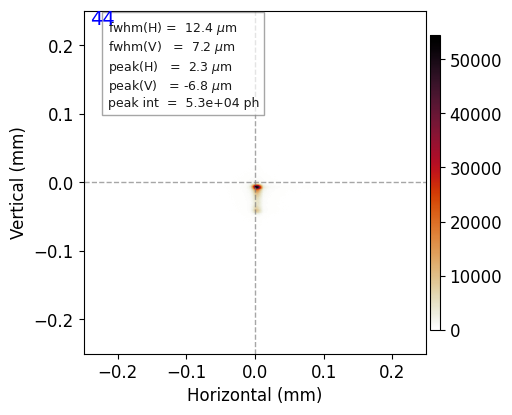

Trial number 50
Trial values: peak_distance 1.464e-02 fwhm 1.301e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39743042543653634, 'h_fwhm': 0.010404817044928905, 'h_centroid': -0.001342546807733519, 'h_peak': -0.014631773969430356, 'v_sigma': 0.4659961970757, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.005613074276078683, 'v_peak': 0.0003251270027353485, 'integral_intensity': 274.0200157519639, 'peak_intensity': 64993.0, 'gaussian_fit': {}}}
Params:
{'hb_1': -34.0, 'hb_2': 10.0, 'hb_pitch': -0.0002500000000000002, 'hb_trans': -0.03740000000000002, 'vb_bender': -62.0, 'vb_pitch': -0.0038299999999999996, 'vb_trans': 0.07500000000000001}


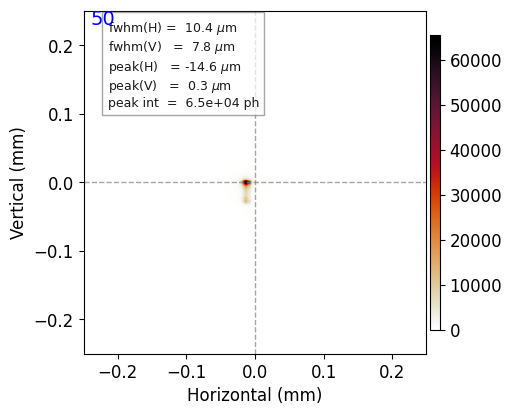

Trial number 56
Trial values: peak_distance 5.405e-02 fwhm 1.263e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3970026941762116, 'h_fwhm': 0.010404817044928905, 'h_centroid': -0.0026348287993332997, 'h_peak': -0.04974803149606299, 'v_sigma': 0.46529963858562484, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.006473661248330792, 'v_peak': -0.02113325517780386, 'integral_intensity': 274.9329351638883, 'peak_intensity': 64903.9, 'gaussian_fit': {}}}
Params:
{'hb_1': -34.0, 'hb_2': 9.0, 'hb_pitch': -4.99999999999997e-05, 'hb_trans': -0.02149999999999999, 'vb_bender': -68.0, 'vb_pitch': -0.0037699999999999995, 'vb_trans': 0.0529}


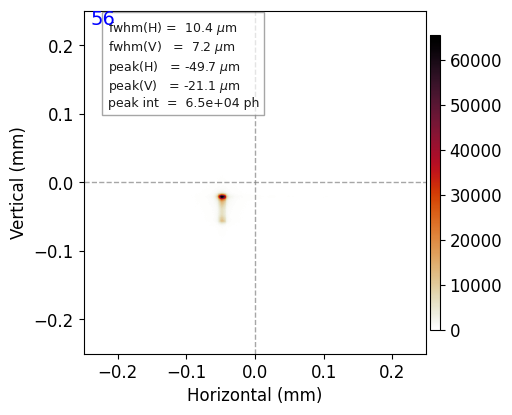

Trial number 85
Trial values: peak_distance 2.219e-02 fwhm 1.341e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3969353155944194, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.0012699322130384216, 'h_peak': -0.013981472904122291, 'v_sigma': 0.4652050874571173, 'v_fwhm': 0.010404064087534692, 'v_centroid': 0.004942748903303706, 'v_peak': 0.017231731144978495, 'integral_intensity': 275.0394013829175, 'peak_intensity': 65390.492, 'gaussian_fit': {}}}
Params:
{'hb_1': -40.0, 'hb_2': 13.0, 'hb_pitch': -0.0004000000000000002, 'hb_trans': -0.01880000000000001, 'vb_bender': -63.0, 'vb_pitch': -0.0018699999999999993, 'vb_trans': -0.038500000000000006}


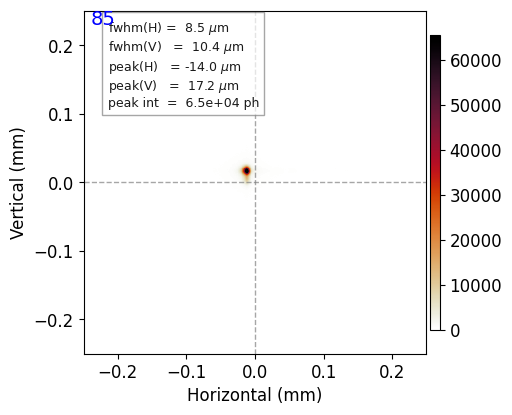

Trial number 88
Trial values: peak_distance 3.707e-03 fwhm 1.517e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3968078903818005, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0008661593715613147, 'h_peak': -0.0029263547938860714, 'v_sigma': 0.46511471960479805, 'v_fwhm': 0.013005080109418365, 'v_centroid': 0.005690764961103961, 'v_peak': -0.0022758890191481784, 'integral_intensity': 275.1684382238761, 'peak_intensity': 65064.848, 'gaussian_fit': {}}}
Params:
{'hb_1': -40.0, 'hb_2': 13.0, 'hb_pitch': -0.0004499999999999999, 'hb_trans': -0.031700000000000006, 'vb_bender': -70.0, 'vb_pitch': -0.0022499999999999994, 'vb_trans': -0.03140000000000001}


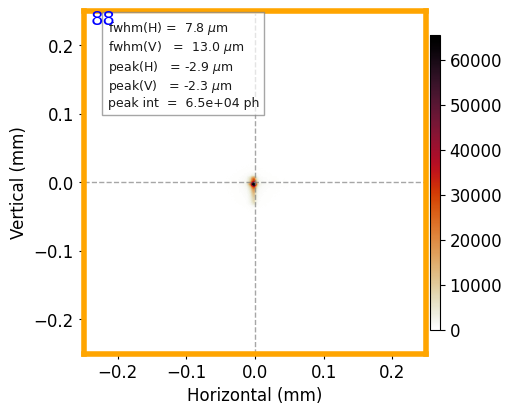

Trial number 89
Trial values: peak_distance 1.238e-02 fwhm 1.301e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3967589587527434, 'h_fwhm': 0.010404817044928905, 'h_centroid': -0.00045039269667218607, 'h_peak': 0.006177860120426101, 'v_sigma': 0.46517991234862255, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.00613798204033722, 'v_peak': -0.01072919109026975, 'integral_intensity': 275.1125799940652, 'peak_intensity': 64970.19, 'gaussian_fit': {}}}
Params:
{'hb_1': -40.0, 'hb_2': 13.0, 'hb_pitch': -0.00185, 'hb_trans': 0.1189, 'vb_bender': -65.0, 'vb_pitch': -0.0036899999999999997, 'vb_trans': 0.05509999999999998}


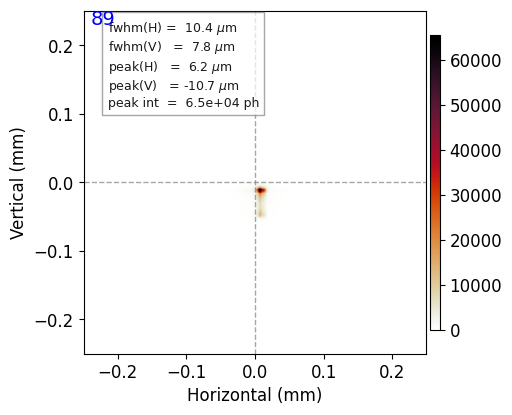

In [21]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)

    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    
    print('Params:')
    print(t.params)

    plt.figure(figsize=[5, 5], constrained_layout=True)
    plt.pcolormesh(
        hists[t.number].hh,
        hists[t.number].vv,
        hists[t.number].data_2D.T[::-1],
        cmap=apu.CMAP,
        #norm=mpl.colors.LogNorm(100, max_count),
        rasterized=True,
    )
    plt.xlim(-0.25, 0.25)
    plt.ylim(-0.25, 0.25)
    plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.xlabel("Horizontal (mm)")
    plt.ylabel("Vertical (mm)")
    # plt.title(t.number)
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect("equal")

    text = (
        rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph"
    )
    # ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
    ax.text(
        0.035 - 0.25,
        0.11,
        text,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    )
    plt.text(-0.24, 0.23, t.number, fontsize=14, color="blue")
    #plt.savefig(f"{out_dir}/pareto_{t.number}.svg", bbox_inches="tight", dpi=600)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color("orange")
    plt.show()

In [22]:
study.best_trials[0].values

[0.2375423575628404, 0.011504617267917006, -10.752291679382324]

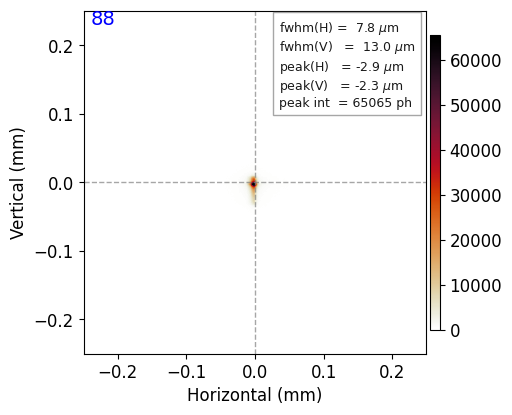

In [23]:
tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]
plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(
    hist.hh, hist.vv, hist.data_2D.T[::-1], cmap=apu.CMAP, rasterized=True
)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title(t.number)
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")


text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.035, 0.11, text, color="black", alpha=0.9, fontsize=9, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)
plt.text(-0.24, 0.23, tnum, fontsize=14, color="blue")
#plt.savefig(f"{out_dir}/pareto_hh.svg", bbox_inches="tight", dpi=600)
plt.show()

In [24]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ["peak_distance", "fwhm", "nlpi"])

In [25]:
pareto_df

,number,peak_distance,fwhm,nlpi,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
26,26,0.237542,0.011505,-10.752292,0.159649,0.175894,0.008454,0.007803,46737.000000
44,44,0.007197,0.014277,-10.878437,0.002276,-0.006828,0.012356,0.007153,53020.667969
50,50,0.014635,0.013006,-11.082035,-0.014632,0.000325,0.010405,0.007803,64993.000000
56,56,0.054051,0.012626,-11.080663,-0.049748,-0.021133,0.010405,0.007153,64903.898438
85,85,0.022190,0.013406,-11.088132,-0.013981,0.017232,0.008454,0.010404,65390.492188
88,88,0.003707,0.015167,-11.083139,-0.002926,-0.002276,0.007804,0.013005,65064.847656
89,89,0.012381,0.013006,-11.081684,0.006178,-0.010729,0.010405,0.007803,64970.191406


In [26]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [27]:
c2

[26, 44, 50, 56, 85, 89]

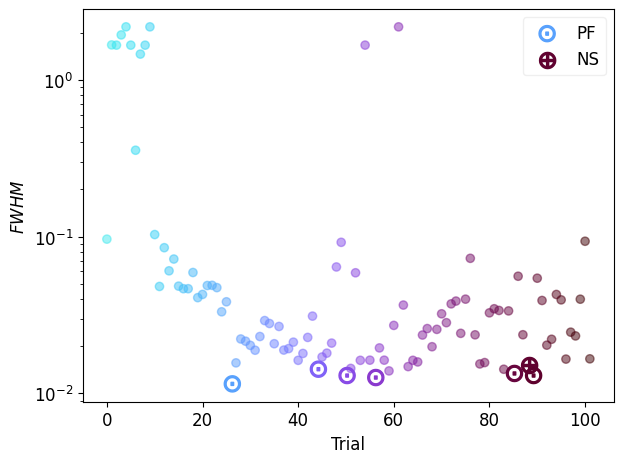

In [28]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

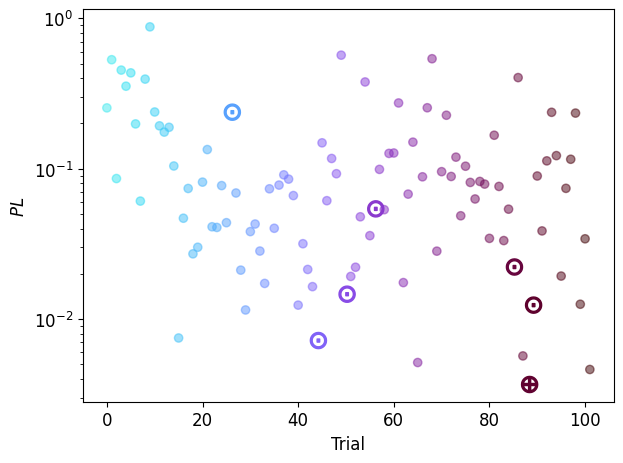

In [29]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$PL$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

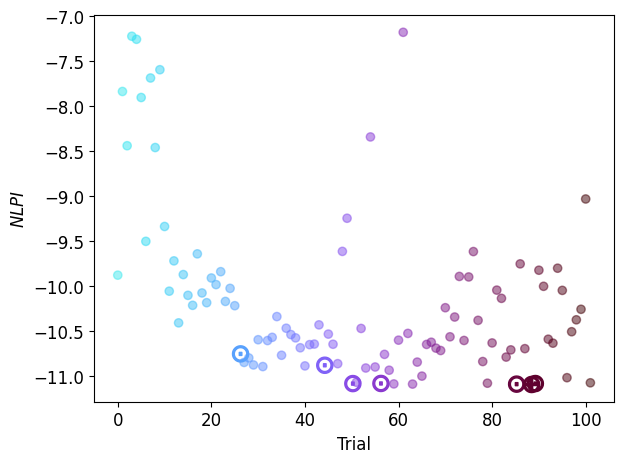

In [30]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$NLPI$")
plt.tight_layout()
plt.show()

In [31]:
ground = {"peak_distance": 2.244e-02, "fwhm": 1.985e-02, "nlpi": -1.081e01}

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_71471/2282941871.py:29: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.463644618893228 4.352882222222223


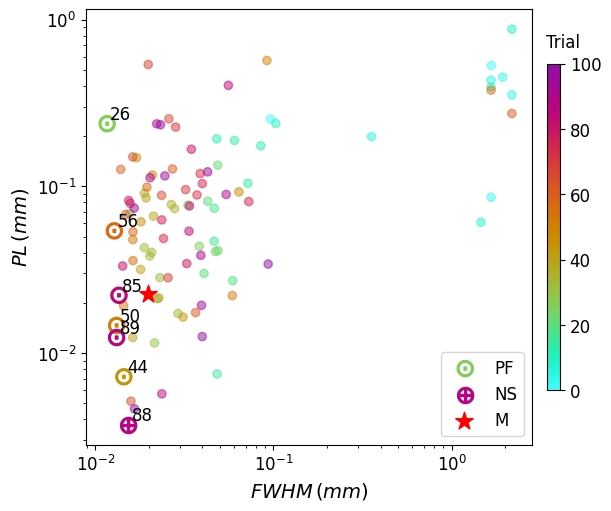

In [32]:
x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$FWHM\,(mm)$", fontsize=14)
plt.ylabel("$PL\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 105.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

plt.scatter(ground["fwhm"], ground["peak_distance"], color="red", marker="*", s=175, label="M")
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
#plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)
plt.show()

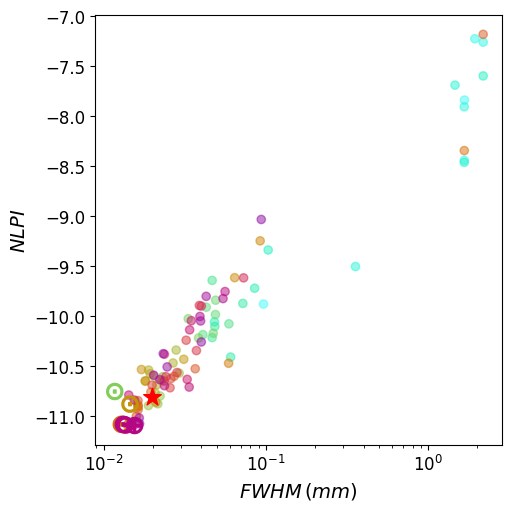

In [33]:
plt.figure(figsize=[5, 5], constrained_layout=True)
x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)
plt.xscale("log")
# plt.yscale('log')
plt.xlabel("$FWHM\, (mm)$", fontsize=14)
plt.ylabel("$NLPI$", fontsize=14)

plt.scatter(ground["fwhm"], ground["nlpi"], color="red", marker="*", s=175, label="M")
# plt.legend(loc='best')
# plt.tight_layout()

#plt.savefig(f"{out_dir}/pareto_fwhm_nlpi.svg", bbox_inches="tight", dpi=600)
plt.show()

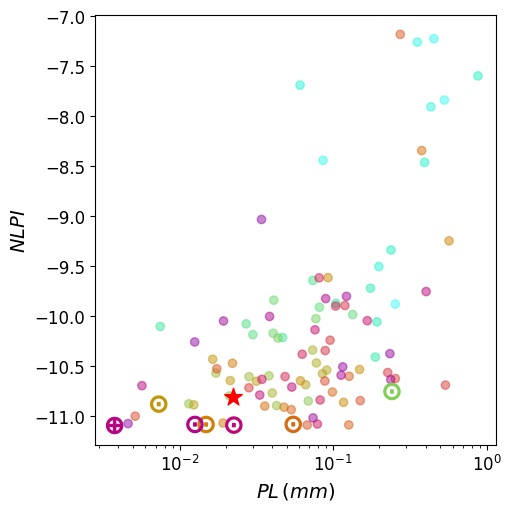

In [34]:
plt.figure(figsize=[5, 5], constrained_layout=True)
x = np.array([t.values[0] for t in study.trials])
y = np.array([t.values[2] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF"
)
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.tropical_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)
plt.xscale("log")
# plt.yscale('log')
plt.xlabel("$PL\,(mm)$", fontsize=14)
plt.ylabel("$NLPI$", fontsize=14)

plt.scatter(ground["peak_distance"], ground["nlpi"], color="red", marker="*", s=175, label="M")
# plt.legend(loc='best')
# plt.tight_layout()

#plt.savefig(f"{out_dir}/pareto_pl_nlpi.svg", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [35]:
import matplotlib.gridspec as gridspec

In [36]:
ground = {
    "FWHM": opt_common._get_fwhm_from_dw(ref_dw),
    "PL": opt_common._get_peak_distance_from_dw(ref_dw),
    "NLPI": -np.log(opt_common._get_peak_intensity_from_dw(ref_dw)),
}

ground = None

In [37]:
props = apu.AnalyzedProps(study, nash_trial, max_count=max_count, min_count=200, xylim=0.25, photon_count_str="3.1e")

In [38]:
out_dir

PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/peak_fwhm_nlpi/all_motors_worse')

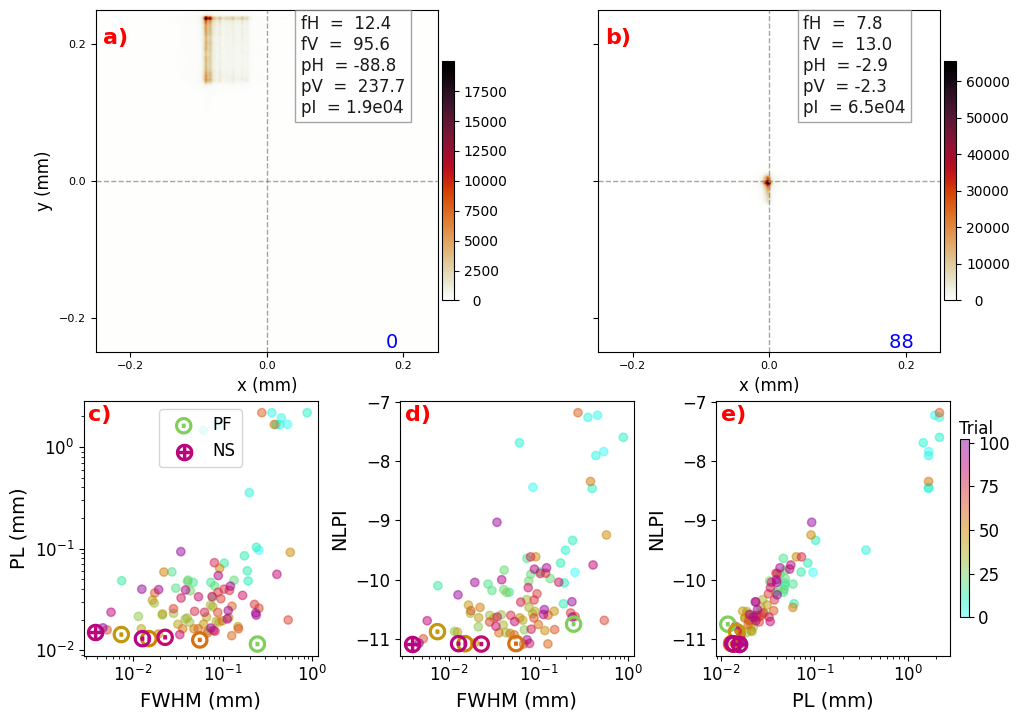

In [29]:
fig = plt.figure(figsize=[10, 7], layout="constrained")
#gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[0.44, 0.21, 0.35])
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.55, 0.45])

# top row
gss0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

axs0 = gss0.subplots(sharex=True, sharey=True)


#cmesh, sublabel = apu.plot_hist_2d(props, axs0[0], ref_hist, ylabel=True)
#apu.add_text_to_hist(props, axs0[0], ref_dw)


cmesh0, sublabel = apu.plot_hist_2d(props, axs0[0], hists[0], study_num=0, sublabel='a', ylabel=True)
apu.add_text_to_hist(props, axs0[0], study.trials[0].user_attrs["dw"], fontsize=12)

cmesh1, sublabel = apu.plot_hist_2d(props, axs0[1], hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel)
apu.add_text_to_hist(props, axs0[1], study.trials[nash_trial.number].user_attrs["dw"], fontsize=12)
# _, sublabel = apu.

for ix, cmesh in enumerate([cmesh0, cmesh1]):
    cbar = fig.colorbar(cmesh, ax=axs0[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=10)
    axs0[ix].locator_params(nbins=4)

# middle row
#gss1 = gridspec.GridSpecFromSubplotSpec(1, len(study.best_trials) - 1, subplot_spec=gs0[1])

#axs1 = gss1.subplots(sharex=True, sharey=True)

#_trials = [t for t in study.best_trials if t.number != nash_trial.number]

#for ix, t in enumerate(_trials):

#    ylabel = True if ix == 0 else False
#    _, sublabel = apu.plot_hist_2d(
#        props,
#        axs1[ix],
#        hists[t.number],
#        study_num=t.number,
#        sublabel=sublabel,
#        ylabel=ylabel,
#        labelfontsize=10,
#        study_num_kwargs={"size": 12},
#    )
#    apu.add_text_to_hist(props, axs1[ix], dw=t.user_attrs["dw"], fontsize=7.5, x=0.55, y=0.6)

# bottom row

gss2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1])
axs2 = gss2.subplots()

cscatter, sublabel = apu.plot_pareto_2d(
    props, axs2[0], "FWHM", "PL", sublabel=sublabel, ground=ground, annotate=False, legend=True, legend_loc="upper center"
)
_, sublabel = apu.plot_pareto_2d(props, axs2[1], "FWHM", "NLPI", sublabel=sublabel, ground=ground)
_, sublabel = apu.plot_pareto_2d(props, axs2[2], "PL", "NLPI", sublabel=sublabel, ground=ground)

cbar = plt.colorbar(cscatter, ax=axs2, pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, 105.0, "Trial")

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0.05, wspace=0.01)
plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{out_dir}/fig_combined.png", bbox_inches="tight", dpi=600)
plt.show()

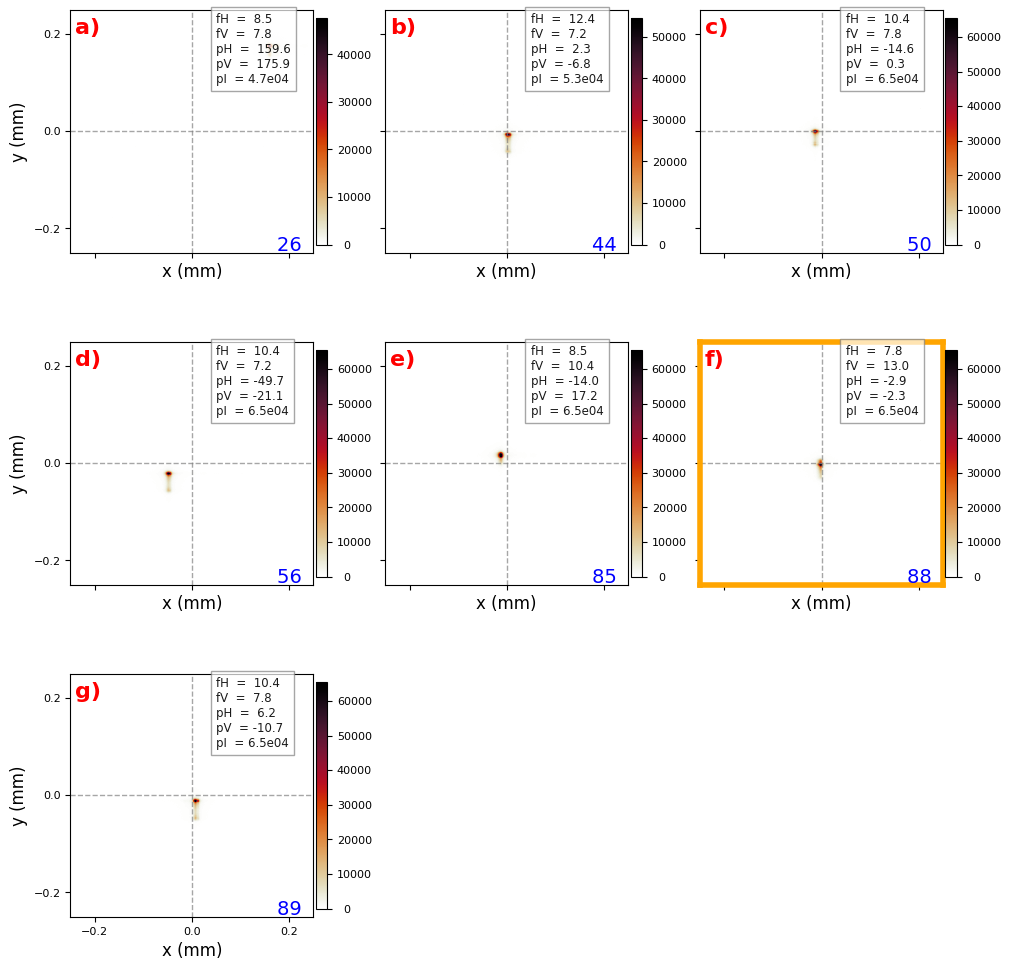

In [31]:
fig, axs = plt.subplots(rows, 3, figsize=[10,10], layout="constrained", sharex=True, sharey=True)
sublabel = 'a'
axs = axs.flatten()
for ax in axs:
    ax.set_visible(False)


for ix, t in enumerate(study.best_trials):
    n = t.number
    axs[ix].set_visible(True)

    ylabel = False
    if ix % 3 == 0: 
        ylabel = True
    cmesh, sublabel = apu.plot_hist_2d(props, axs[ix], hists[n], study_num=n, sublabel=sublabel, ylabel=ylabel)
    apu.add_text_to_hist(props, axs[ix], t.user_attrs["dw"], fontsize=8.5)

    cbar = fig.colorbar(cmesh, ax=axs[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=8)

    axs[ix].locator_params(nbins=4)

    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            axs[ix].spines[axis].set_linewidth(4)
            axs[ix].spines[axis].set_color("orange")

plt.savefig(f"{out_dir}/pareteo_trials.pdf", bbox_inches="tight", dpi=600)

plt.savefig(f"{out_dir}/pareteo_trials.png", bbox_inches="tight", dpi=600)
plt.show()

#### The remaining part is just testing how lwsi with thresholding performs in selecting the structures. This is for my own satisfaction. - SK

In [ ]:
isums = []
wsums_no_thres = []
wsums_thres = []
for h in hists:
    isum1, wsum1 = analysis.calculate_weighted_sum(h, threshold=0)
    isum2, wsum2 = analysis.calculate_weighted_sum(h)
    isums.append((isum1, isum2))
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
isums = np.array(isums)
wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)

In [ ]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: np.log(wsums_no_thres[t.number]), target_name="log_weighted_sum without thresholding"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    study, target=lambda t: np.log(wsums_thres[t.number]), target_name="log_weighted_sum after thresholding"
)
for t in study.best_trials:
    plt.axvline(t.number, color="red")
plt.axvline(nash_trial.number, color="green")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
test_val_fns = [lambda t: t.values[0], lambda t: t.values[2], lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, study.directions, values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1, 1], test_val_fns)
print(np.argmax(domins))

In [ ]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]

    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:, None], hdata.data_2D[700:-700, 700:-700].T)
    plt.show()

In [ ]:
test_val_fns = [
    lambda t: t.values[0],
    lambda t: opt_common._get_fwhm_from_dw(t.user_attrs["dw"]),
    lambda t: np.log(wsums_thres[t.number]),
]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1, 1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])